In [1]:
import numpy as np
import pandas as pd

from scipy.signal import stft #Short Time Fourier Transform
from scipy.spatial.distance import seuclidean #Standardized Euclidean Distance
from scipy.stats import chi2 #Chi square distribution

from dask.distributed import Client
import dask.bag as db
from glob import glob

from datetime import datetime

In [2]:
def getParams(fs, alphaMax=2000, dfreq=1500, fMin=5e+4):
    # produces the parameters for the cyclic spectrum estimation
    
    # fs - samping rate [sample/sec]
    # alphaMax - max modulation frequency [Hz]
    # dfreq - carrier frequency resolution [Hz]
    # fMin - min carrier frequency [Hz]

    # STFT windows' hop [sample]
    R = int(np.floor(fs / (2 * alphaMax))) 
    # STFT window length [sample]
    Nw = int(fs / dfreq)

    # Hanning window
    w = np.hanning(Nw)
    # Dirichlet kernel parameter (oreder)
    P = int(np.round((Nw - 1) / (2 * R)))
    # Dirichlet kernel
    D = np.sum(
        [np.exp(2 * np.pi * 1j * p *(np.arange(Nw) - Nw / 2) / Nw) for p in np.arange(- P, P + 1)], 
        axis=0
    )
    D = D.real
    return fMin, R, Nw, w, D

In [3]:
def getCS(x, fs, approxCoh=True, normalization=False, alphaMax=2000, dfreq=1500): 
    # An implementation of the cyclic spectral correlation and cyclic spectral coherence according to 
    # Borghesani, P., and J. Antoni. "A faster algorithm for the calculation of the fast spectral correlation." 
    # Mechanical Systems and Signal Processing 111 (2018): 113-118.
    
    #inputs:
    # x - signal
    # fs - sampling rate [sample/sec]
    # approxCoh - neglect the deviation of the carrier freqeuncy due to the computation 
    # method for the estimation of the coherence Sxx(f-2 * alpha) = Sxx(f) 
    # normalization - calculation of the normalization factor
    # alphaMax - maximal modulation frequency [Hz]
    # dfreq - minimal carrier frequency [Hz]
    
    # comment: 
    # another approximation is applied always: S(f, alpha)=S(f-2*alpha, alpha)
    # this part should not affect the detection and it is mainly cosmetic
    
    fMin, R, Nw, w, D = getParams(fs, alphaMax=alphaMax, dfreq=dfreq)

    # STFT with with Hanning window 
    X_w = stft(x, fs=fs, window=w, nperseg=Nw, noverlap=Nw - R, nfft=Nw, return_onesided=True)[-1]
    # STFT with with Hanning multiplied by Dirichlet kernel window
    f, t, X_w_d = stft(x, fs=fs, window=w * D, nperseg=Nw, noverlap=Nw - R, nfft=Nw, return_onesided=True)

    if approxCoh:
        # here I save some computation time by removing the frequencies below fMin.
        X_w = X_w[f >= fMin, :-1]
        X_w_d = X_w_d[f >= fMin, :-1]

    # Cyclcic Spectrum
    CS = np.fft.fft(np.conjugate(X_w) * X_w_d, axis=1).T
    # Modulation frequency vector
    alpha = np.fft.fftfreq(X_w_d.shape[1], R / fs)
    # remove the negative modulation frequency part
    pistiveAlphaCond = alpha >= 0
    CS = CS[pistiveAlphaCond, :]
    alpha = alpha[pistiveAlphaCond]

    if normalization:
        # here, implemented the normalization but did not find it useful - the results' improvement is not impressive.
        normalizingFactor = np.fft.fft((w**2) * D, int(R * (1 + (x.size - Nw) / R)))[:np.sum(pistiveAlphaCond)]
        normalizingFactor *= fs * X_w_d.shape[1]
        CS = (CS.T / normalizingFactor).T
        normalizingFactor_abs = np.abs(normalizingFactor)
        normalizingFactorCond = normalizingFactor_abs / np.max(normalizingFactor_abs) > 0.95
        CS = CS[normalizingFactorCond, :]
    else:
        normalizingFactorCond = np.ones(np.sum(pistiveAlphaCond), dtype=bool)


    # Cyclic Coherence
    CS_abs = np.abs(CS)
    if approxCoh:
        # second approximation - neglect the impact of the modulation frquency on the spectrum
        CCoh = CS_abs / CS_abs[0, :]
    else:
        inds = np.atleast_2d(np.arange(f.size)) - np.atleast_2d((np.arange(CS.shape[0]) * Nw) / (R * alpha.size)).T
        inds = inds.astype(int)
        CCoh = CS_abs / np.sqrt(CS_abs[0, :] * CS_abs[0, inds])
        CS = CS[:, f >= fMin]
        CCoh = CCoh[:, f >= fMin]

    alpha = alpha[normalizingFactorCond]
    f = f[f >= fMin]

    return CS, CCoh, f, alpha

In [4]:
def getPvalEES(file, alphaMax=2000, dfreq=1500, alphaLims=[0.01, 0.51], alphaThresh=460):
    #wrapper for getCS + extracter of the p-value between the 100Hz harmonics to the background
    
    #inputs:
    # file - file name
    # alphaMax - max modulation frequency [Hz]
    # dfreq - carrier frequency resolution [Hz]
    # alphaLims - relative limits (0:1) of the feature extractor with respect to the modulation frequency 
    
    df = pd.read_feather(file)
    # rounding sample length for precise frequency resolution
    df = df[df.time_ms < np.round(df.time_ms.values[-1] / 1000) * 1000]
    
    # sampling rate [sample/sec]
    fs = 1000 / df.time_ms[1] 
    
    channNames = df.columns[1:]
    assert channNames.str.contains('adc_signal_mv').all()
    
    pValue = []
    EESs = []
    #iteration over sampling channels
    for ch in channNames:
        x = df[ch].values
        
        CS, CCoh, f, alpha = getCS(x, fs, alphaMax=alphaMax, dfreq=dfreq, normalization=False)
        CCoh_abs_sqrt = np.abs(CCoh.T)**2
        
        # cutting out with respect to the limits of the modulation frequency
        edgeCond = (alpha > alphaMax * alphaLims[0]) & (alpha < alphaMax * alphaLims[1])
        CCoh_abs_sqrt = CCoh_abs_sqrt[:, edgeCond]
        alpha = alpha[edgeCond]
        
        #Enhenced Envelope Spectrum
        EES = CCoh_abs_sqrt.sum(axis=0) 
    
        # condition for harmonics of 100Hz
        cond100 = np.mod(alpha, 100) == 0
        cond360 = alpha > alphaThresh
        EES_PD = EES[cond100 & cond360]
        EESnot100 = EES[~cond100]
        
        # standardized Euclidean distance between the distribution of the background spectrum to the 100Hz harmonics
        SED = seuclidean(
            EES_PD, 
            EESnot100.mean() * np.ones_like(EES_PD), 
            EESnot100.var() * np.ones_like(EES_PD)
        )
        pValue.append(chi2(EES_PD.size).sf(SED))
        EESs.append(EES)
        
    res = {
        'channel': np.arange(1, df.shape[1]),  
        'pValue': pValue, 
        'alpha': alpha, 
        'EESs': EESs, 
        'file': file
    }
    
    return res

### Following allows running a smaller batch of data

In [5]:
# count = {a: 0 for a in list(set(f.split('/')[1].split('_16')[0] for f in files))}
# calcFiles = []
# for f in files[::-1]:
#     for k in count.keys():
#         if k in f:
#             count[k] += 1
#             calcFiles.append(f)
#             break
#     if count[k] == 200:
#         count.pop(k, None)
#     if len(count.keys()) == 0:
#         break
# len(calcFiles)

# files = calcFiles

### Calculation of the features

In [6]:
dfreq=1500
import os
resFold = 'resDF' + str(dfreq)
if not os.path.isdir(resFold):
    os.mkdir(resFold)

In [7]:
with Client() as client:
    display(client)
    d = db.from_sequence(glob('data/*.fthr'))
    df = d.map(getPvalEES, dfreq=dfreq).to_dataframe()
    df.to_parquet(resFold)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52429,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:52443,Total threads: 2
Dashboard: http://127.0.0.1:52444/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:52435,


In [8]:
from glob import glob
df = pd.read_parquet(resFold)
df

,channel,pValue,alpha,EESs,file
__null_dask_index__,,,,,
0,[1],[0.6641521947959048],"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[[0.1009646808129156, 0.08370729994340928, 0.0...",data/T7_ANALOGMAX-1_1636509600.fthr
1,[1],[0.8172247770917507],"[20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24....","[[0.020183671957089935, 0.021806100301286758, ...",data/T7_ANALOGMAX-0_1642460400.fthr
2,"[1, 2, 3, 4]","[0.0004964565081202435, 1.3906406994745523e-18...","[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[[0.11050484505406112, 0.09576417874208451, 0....",data/TRF01_IW976-0032_1636614006.fthr
3,[1],[1.2426313165128253e-17],"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[[0.11848221281586993, 0.09617234618152598, 0....",data/29.5_ANALOGMAX-1_1629774000.fthr
4,[1],[0.8829990013581982],"[20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24....","[[0.025225769967001085, 0.01920856402922013, 0...",data/T7_ANALOGMAX-0_1641852000.fthr
...,...,...,...,...,...
137,[1],[0.8787707565218521],"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[[0.10146827517846006, 0.08078020494870998, 0....",data/T7_ANALOGMAX-1_1635732000.fthr
138,[1],[0.9442154545361393],"[20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24....","[[0.018786744365960107, 0.02097176132386267, 0...",data/T7_ANALOGMAX-0_1645290000.fthr
139,"[1, 2, 3, 4]","[0.7646053828749781, 2.8556517919346883e-09, 0...","[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[[0.23822654276021468, 0.22096437287762194, 0....",data/TRF01_IW976-0032_1630728007.fthr


In [9]:
df = df.assign(sensor=df.file.apply(lambda x: x.split('/')[-1].split('_16')[0]))
df = df.assign(time_num=df.file.apply(lambda x: int(x.split('/')[-1].split('_')[-1].split('.')[0])))
df = df.assign(time=df.time_num.apply(datetime.fromtimestamp))
df = df.reset_index(drop=True)
df = df.explode(column=['channel', 'pValue', 'EESs'])
df

,channel,pValue,alpha,EESs,file,sensor,time_num,time
0,1,0.664152,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.1009646808129156, 0.08370729994340928, 0.08...",data/T7_ANALOGMAX-1_1636509600.fthr,T7_ANALOGMAX-1,1636509600,2021-11-10 04:00:00
1,1,0.817225,"[20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24....","[0.020183671957089935, 0.021806100301286758, 0...",data/T7_ANALOGMAX-0_1642460400.fthr,T7_ANALOGMAX-0,1642460400,2022-01-18 01:00:00
2,1,0.000496,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.11050484505406112, 0.09576417874208451, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06
2,2,0.0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.10943809207251393, 0.10689785903259721, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06
2,3,0.959272,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.12726238424253777, 0.09982054190720752, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06
...,...,...,...,...,...,...,...,...
14276,2,0.0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.1117439256942892, 0.1154517749884377, 0.098...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07
14276,3,0.303992,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.14586045833185446, 0.12087798403397883, 0.1...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07
14276,4,0.320214,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.34913260135439805, 0.3249182303714624, 0.33...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07
14277,1,0.947291,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.09556438572258866, 0.0867749861974989, 0.07...",data/T7_ANALOGMAX-1_1642136400.fthr,T7_ANALOGMAX-1,1642136400,2022-01-14 07:00:00


In [10]:
df = df[~((df.time < '2021-08-15') & (df.sensor=='TRF01_IW976-0032'))]
df = df[~((df.time < '2021-11-01') & (df.sensor=='T7_ANALOGMAX-1'))]
df = df[~((df.time > '2022-02-13') & (df.time < '2022-02-23') & (df.sensor=='TRF10_IW976-0032'))]
df

,channel,pValue,alpha,EESs,file,sensor,time_num,time
0,1,0.664152,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.1009646808129156, 0.08370729994340928, 0.08...",data/T7_ANALOGMAX-1_1636509600.fthr,T7_ANALOGMAX-1,1636509600,2021-11-10 04:00:00
1,1,0.817225,"[20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24....","[0.020183671957089935, 0.021806100301286758, 0...",data/T7_ANALOGMAX-0_1642460400.fthr,T7_ANALOGMAX-0,1642460400,2022-01-18 01:00:00
2,1,0.000496,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.11050484505406112, 0.09576417874208451, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06
2,2,0.0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.10943809207251393, 0.10689785903259721, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06
2,3,0.959272,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.12726238424253777, 0.09982054190720752, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06
...,...,...,...,...,...,...,...,...
14276,2,0.0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.1117439256942892, 0.1154517749884377, 0.098...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07
14276,3,0.303992,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.14586045833185446, 0.12087798403397883, 0.1...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07
14276,4,0.320214,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.34913260135439805, 0.3249182303714624, 0.33...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07
14277,1,0.947291,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.09556438572258866, 0.0867749861974989, 0.07...",data/T7_ANALOGMAX-1_1642136400.fthr,T7_ANALOGMAX-1,1642136400,2022-01-14 07:00:00


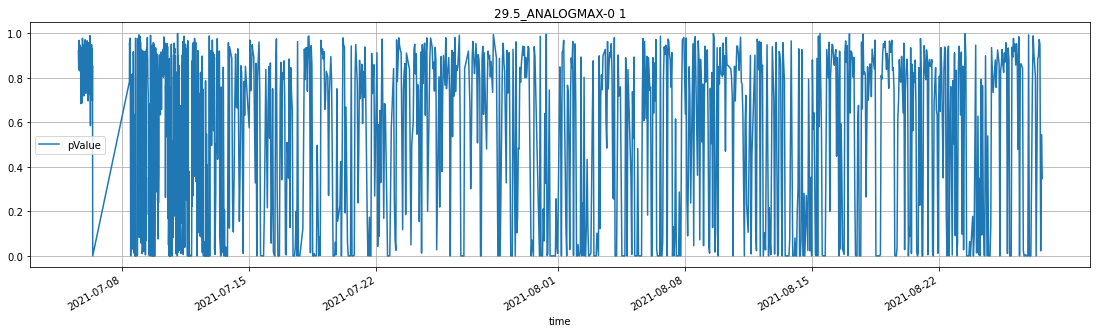

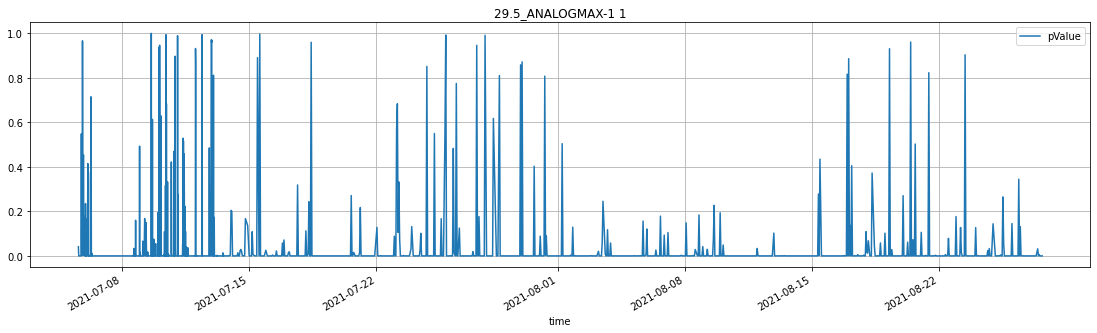

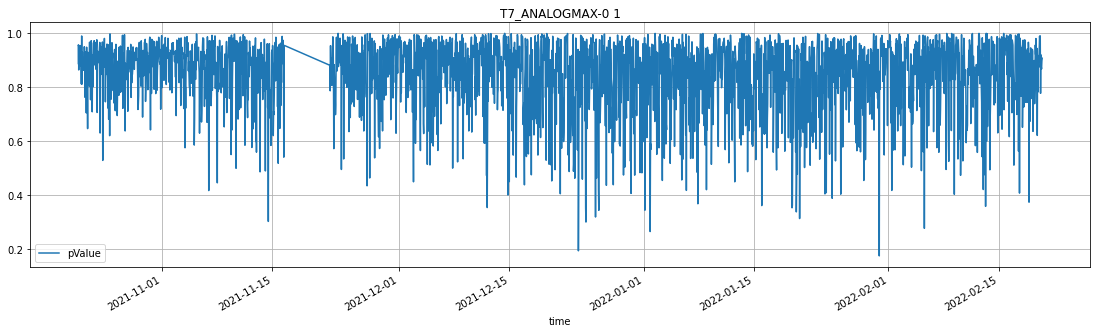

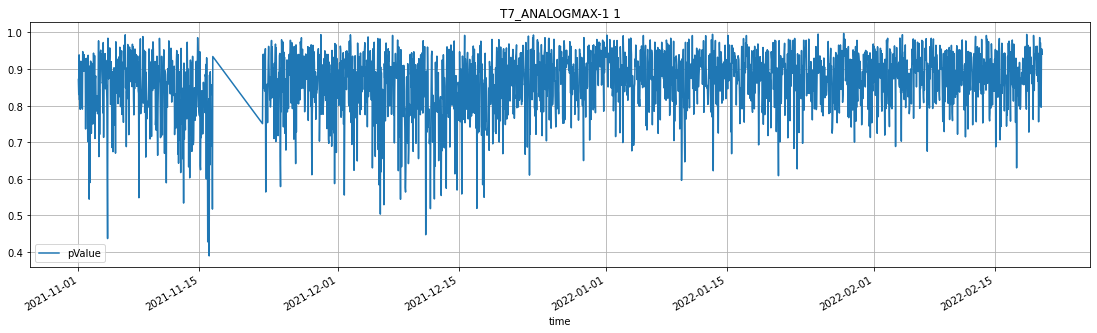

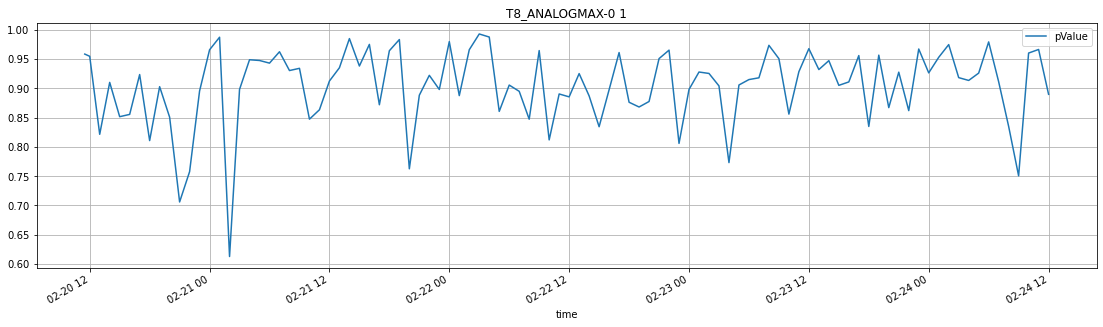

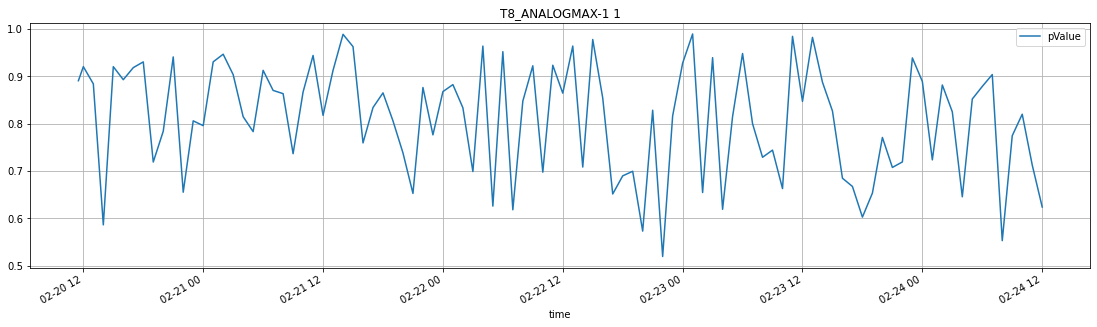

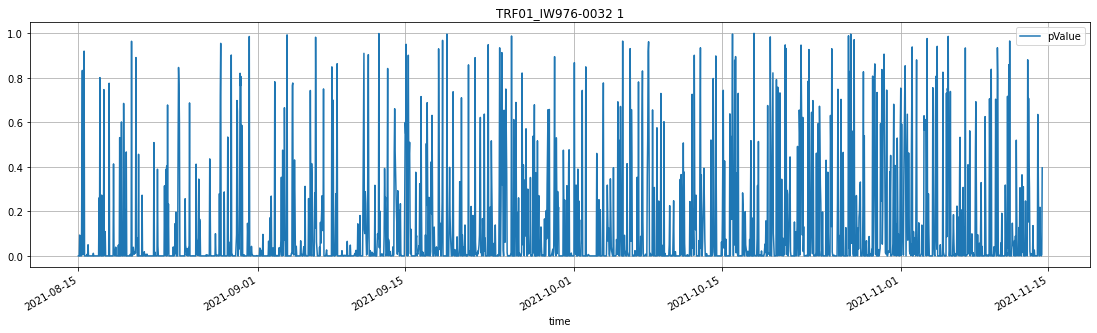

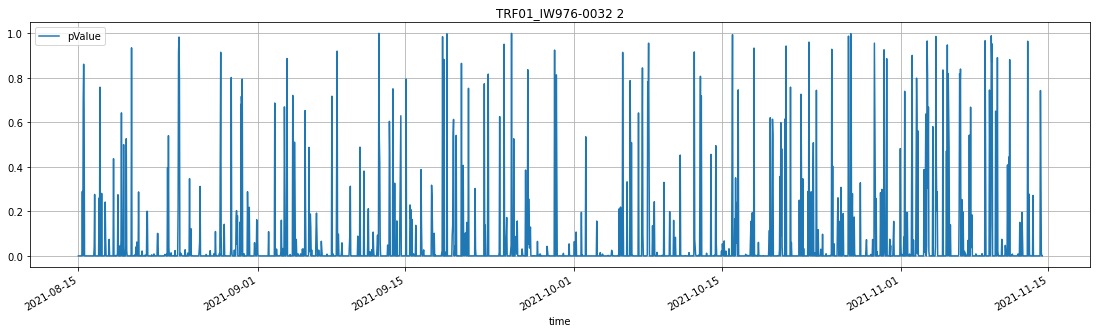

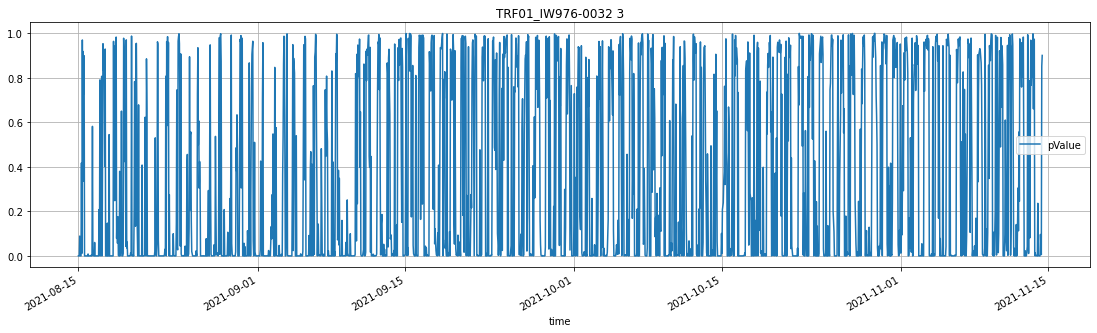

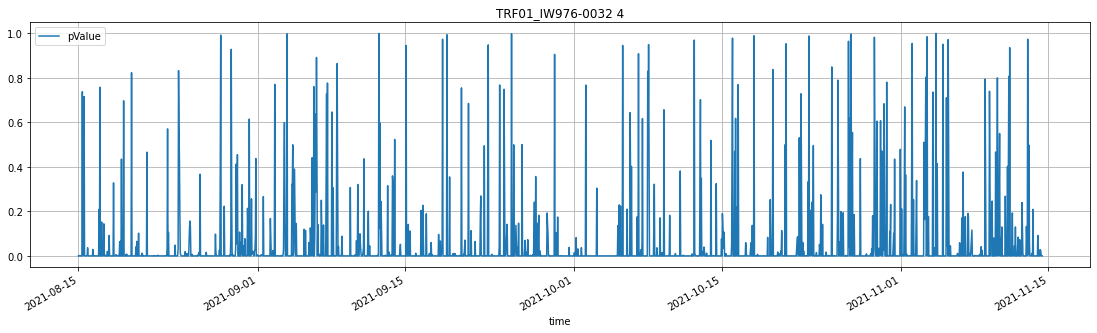

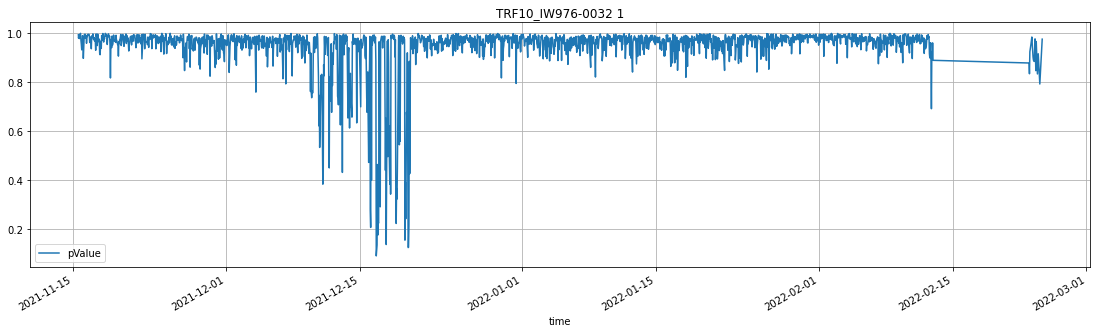

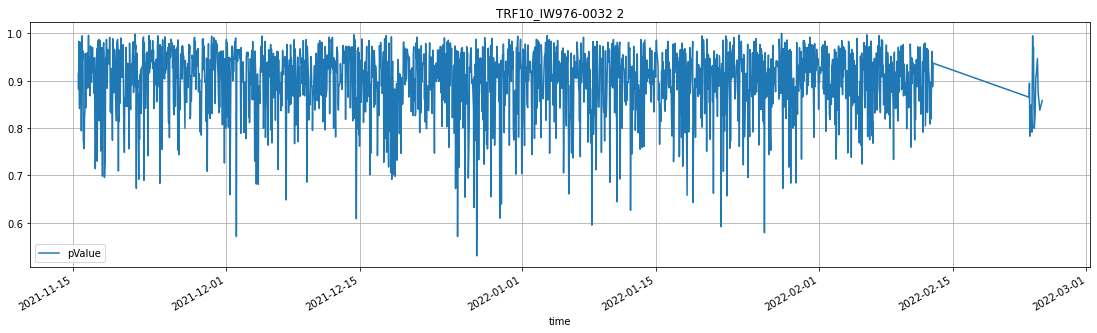

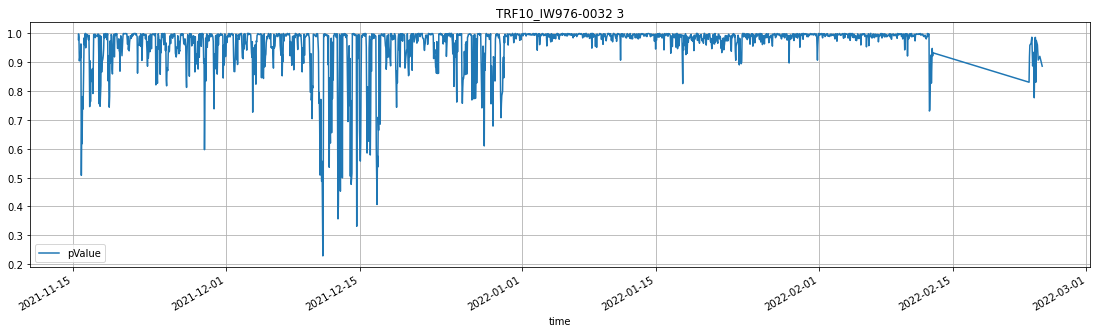

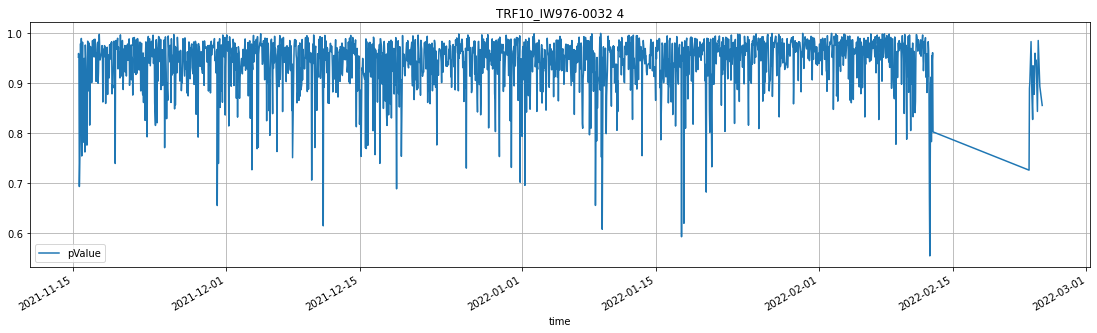

In [11]:
for title, group in df.groupby(['sensor', 'channel']):
    ax = group.plot(x='time', y='pValue', title=str(title[0])+ ' ' + str(title[1]), figsize=(19, 5))
    ax.grid()

In [12]:
df = df.assign(PD=df.sensor.apply(lambda x: not (('T7' in x) or ('TRF10' in x))))
df

,channel,pValue,alpha,EESs,file,sensor,time_num,time,PD
0,1,0.664152,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.1009646808129156, 0.08370729994340928, 0.08...",data/T7_ANALOGMAX-1_1636509600.fthr,T7_ANALOGMAX-1,1636509600,2021-11-10 04:00:00,False
1,1,0.817225,"[20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24....","[0.020183671957089935, 0.021806100301286758, 0...",data/T7_ANALOGMAX-0_1642460400.fthr,T7_ANALOGMAX-0,1642460400,2022-01-18 01:00:00,False
2,1,0.000496,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.11050484505406112, 0.09576417874208451, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06,True
2,2,0.0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.10943809207251393, 0.10689785903259721, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06,True
2,3,0.959272,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.12726238424253777, 0.09982054190720752, 0.1...",data/TRF01_IW976-0032_1636614006.fthr,TRF01_IW976-0032,1636614006,2021-11-11 09:00:06,True
...,...,...,...,...,...,...,...,...,...
14276,2,0.0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.1117439256942892, 0.1154517749884377, 0.098...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07,True
14276,3,0.303992,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.14586045833185446, 0.12087798403397883, 0.1...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07,True
14276,4,0.320214,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.34913260135439805, 0.3249182303714624, 0.33...",data/TRF01_IW976-0032_1630728007.fthr,TRF01_IW976-0032,1630728007,2021-09-04 07:00:07,True
14277,1,0.947291,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.09556438572258866, 0.0867749861974989, 0.07...",data/T7_ANALOGMAX-1_1642136400.fthr,T7_ANALOGMAX-1,1642136400,2022-01-14 07:00:00,False


,alpha,EESs
0,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.07713927993576145, 0.09077778182972651, 0.0..."
1,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.0950759051989988, 0.08935856431412836, 0.07..."
2,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.09854898964046918, 0.09447649355258131, 0.0..."
3,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.07751281367902331, 0.09079889782855793, 0.0..."
4,"[21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....","[0.081720163023587, 0.09602819871520575, 0.101..."


NameError: name 'plt' is not defined

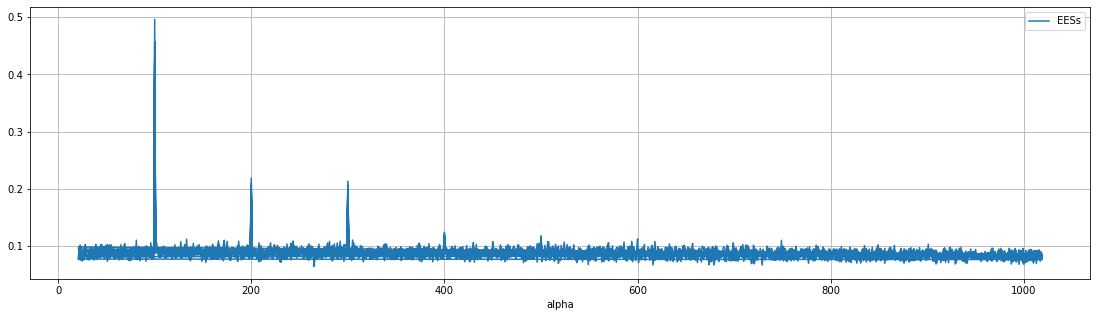

In [13]:
dfTemp = df[df.sensor.str.contains('T8')].sort_values(by='pValue').head(5).reset_index(drop=True)
dfTemp = dfTemp.loc[-1:, ['alpha', 'EESs']]
display(dfTemp)
dfTemp.explode(['alpha', 'EESs']).plot(x='alpha', grid=True, figsize=[19, 5])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

TP = []
FP = []
for th in np.arange(0, 1.01, 0.01):
    dfTemp = df.assign(detectPD=df.pValue < th)
    dfTemp[dfTemp.PD].groupby(['sensor', 'channel'])['detectPD'].mean().reset_index()
    TP.append(dfTemp.loc[dfTemp.PD].groupby(['sensor', 'channel'])['detectPD'].mean().mean())
    FP.append(dfTemp.loc[~dfTemp.PD].groupby(['sensor', 'channel'])['detectPD'].mean().mean())
plt.figure(figsize=[10, 10])
plt.plot(FP, TP)
plt.xlabel('FP')
plt.ylabel('TP')
plt.xticks(np.arange(0, 1, 0.05))
plt.yticks(np.arange(0, 1, 0.05))
plt.autoscale(enable=True, tight=True)
plt.title("ROC: AUC={:.3f}".format(np.trapz(TP, FP)))
plt.grid()
plt.show()

In [ ]:
import plotly.express as px
fig = px.ecdf(
    df.assign(sensor=df.sensor + '-' + df.channel.apply(str)),  
    x='pValue',
    color='sensor',
    title='CDF'
)
fig.show()
fig.write_html('cdf.html')

In [ ]:
def plotRow(row):
    plt.figure(figsize=[19, 5])
    plt.plot(row['alpha'], row['EESs'])
    plt.grid()
    plt.title(row['file'].split('.')[0].split('/')[-1] + '  - channel ' + str(row['channel']))
    plt.show()
#plotting the false alarms
dfFP = df[(~df.PD) & (df.pValue < 0.2)].sort_values(by='sensor')
dfFP.apply(plotRow, axis=1);

In [ ]:
dfFP

### Code for avro files - runs significantly slower

In [ ]:
# def getPvalEESavro(avroDict, alphaMax=2000, dfreq=1500, alphaLims=[0.01, 0.51]):
#     #wrapper for getCS + extracter of the p-value between the 100Hz harmonics to the background
    
#     #inputs:
#     # file - file name
#     # alphaMax - max modulation frequency [Hz]
#     # dfreq - carrier frequency resolution [Hz]
#     # alphaLims - relative limits (0:1) of the feature extractor with respect to the modulation frequency 
    
#     # sampling rate [sample/sec]
#     fs = avroDict['samplerate']
    
#     pValue = []
#     EESs = []
#     #iteration over sampling channels
#     for x in avroDict['adc_signal_mv']:
#         # rounding sample length for precise frequency resolution
#         x = x[:int(np.floor(len(x) / fs) * fs)]
        
#         CS, CCoh, f, alpha = getCS(x, fs, alphaMax=alphaMax, dfreq=dfreq, normalization=False)
#         CCoh_abs = np.abs(CCoh.T)
        
#         # cutting out with respect to the limits of the modulation frequency
#         edgeCond = (alpha > alphaMax * alphaLims[0]) & (alpha < alphaMax * alphaLims[1])
#         CCoh_abs = CCoh_abs[:, edgeCond]
#         alpha = alpha[edgeCond]
        
#         #Enhenced Envelope Spectrum
#         EES = CCoh_abs.sum(axis=0) 
    
#         # condition for harmonics of 100Hz
#         cond100 = np.mod(alpha, 100) == 0
#         cond360 = alpha > 360
#         EES_PD = EES[cond100 & cond360]
#         EESnot100 = EES[~cond100]
        
#         # standardized Euclidean distance between the distribution of the background spectrum to the 100Hz harmonics
#         SED = seuclidean(
#             EES_PD, 
#             EESnot100.mean() * np.ones_like(EES_PD), 
#             EESnot100.var() * np.ones_like(EES_PD)
#         )
#         pValue.append(chi2(EES_PD.size).sf(SED))
#         EESs.append(EES)
        
#     res = {
#         'channel': np.arange(len(avroDict['adc_signal_mv'])),  
#         'pValue': pValue, 
#         'alpha': alpha, 
#         'EESs': EESs, 
#         'timestamp': avroDict['timestamp'],
#         'id': avroDict['id']
#     }
    
#     return res

In [ ]:
# with Client() as client:
#     display(client)
#     d = db.read_avro(glob('dataAvro/*'), blocksize=None)
#     df = d.map(getPvalEESavro).to_dataframe()
#     df.to_parquet(resFile+'_avro')